## Анализ различий в состояниях

Идея 1. Предположим, что полная выборка - это ground true. Оставляем только значимые пары с FDR коррекцией 0.05.    Анализируем как воспроизводятся индивидуальные эффекты: индивидуально, частость каждого ребра (отдельно положительного, отдельно отрицательного). Считаем precision, recall для разных подгруп. Смотрим насколько воспроизводится паттерн целиком (dice эффект).
	1) Можно сделать для разных способов коррекции
	2) Протестировать насколько NBS может изменить ситуацию
	3) Проверить IHW подход и получить веса на полной выборке
**Зачем это надо**  Во первых опубликуем полученные эффекты, которые можно использовать (например как мы сами во второй части). Получим оценки размеров эффектов, шансы на их выявления по размерам групп, оценки Точности (доля правильно выявлянных эффектов) и Полноты (доля выявлянных эффектов) для подгруппы и сделаем какие то рекомендации по размерам. Сравним разные способы коррекции на множественные сравнения и посмотрим насколько хорош подход с nbs
3) Идея 2. Нет никакой ground true, можем брать выборки меньших размеров и смотреть следующее:
	1) Частость паттерна при разных коррекциях (чем выше, тем лучше) для подгрупп
	2) Dice для подгрупп
	3) добавляем веса с IHW
В качестве значимых берем:
 - нескорректированный p-val (одно экстремальное состояние)
 - коррекцию на множественные сравнения (тогда вообще надо объединять все гипотезы и все бэнды в один датасет):
	 - fwer
	 - fdr (+версии)
	 -  nbs
	 - ihw+ все способы, веса получаем из ground true. Как это использовать другими? Мы можем опубликовать веса для каналов и предлагать их использовать в схожих задачах как ковариату, например если нам надо убрать эффект открытых закрытых глаз или наоборот проверить. 
Оценки для множественных сравнений и  ihw отсюда : https://puolival.github.io/multipy/

**Зачем это надо**  Получим оценки воспроизводимости для разных размеров групп и сравним разные способы коррекции, посмотрим как априорное знание позволяет улучшить вариант. От первого пункта основное отличие в том, что нет ground true, к которому можно придраться

In [2]:
import sys
sys.path.append("..")

In [3]:
from table_analyzer import SynchronizationTable, bool_dice, vec_2_arr_bool_dice
from plotting_utils import DrawEEG
from table_analyzer import pairwise_bool_dice
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import cm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [129]:
df = pd.read_csv('../eeg_dataframe_nansfilled.csv', index_col=0)
df.head()

,Fp1/Fp2_1_fo,Fp1/F7_1_fo,Fp1/F3_1_fo,Fp1/Fz_1_fo,Fp1/F4_1_fo,Fp1/F8_1_fo,Fp1/T3_1_fo,Fp1/C3_1_fo,Fp1/Cz_1_fo,Fp1/C4_1_fo,...,Pz/P4_7_fz,Pz/T6_7_fz,Pz/O1_7_fz,Pz/O2_7_fz,P4/T6_7_fz,P4/O1_7_fz,P4/O2_7_fz,T6/O1_7_fz,T6/O2_7_fz,O1/O2_7_fz
abs_,-0.067816,-0.190843,0.197049,0.082941,-0.431078,-0.880805,-1.597362,-0.486399,-0.505033,-0.634386,...,-0.369614,-1.591706,-0.671730,-0.722746,-1.030530,-1.353433,-0.547397,-2.283078,-0.838246,-1.366732
agv_,-0.063064,0.149510,-1.470177,-2.307671,-4.443682,-1.542283,-1.490230,-1.053519,-1.771533,-3.276315,...,-0.399129,-1.244996,-0.463251,-0.535564,-1.440858,-1.157720,-0.681816,-1.764711,-0.533204,-1.412399
ami_,-0.456335,-0.437952,-0.133411,-0.656705,-0.498032,-1.281238,-1.952807,-1.150458,-1.865200,-1.718330,...,-0.100816,-0.595306,-0.283766,-0.117159,0.246866,-0.786120,0.194194,-0.788818,-0.051139,-0.387762
ast_,-1.161369,-1.080370,-1.011179,-1.569420,-3.917162,-2.127779,-2.692695,-2.732259,-2.059262,-3.841575,...,-0.077291,-1.674175,-0.636853,-0.970301,-0.401405,-0.866471,0.059785,-1.264972,0.262019,-0.799658
avk_,-1.344665,-3.841575,-4.795873,-3.105343,-3.917162,-2.839805,-1.620330,-3.074839,-2.087983,-1.828024,...,-0.516737,-2.283078,-0.907005,-0.545027,-1.792309,-2.550227,-1.661937,-0.818822,-0.491047,-0.869325


In [130]:
%%time
full_table = SynchronizationTable(df)
stat_df = full_table.compute_stat_df(bts_num=1000)

CPU times: user 3.15 s, sys: 65 ms, total: 3.21 s
Wall time: 3.37 s


In [66]:
stat_df.head()

,chan_pair,band,p_val,sign_holm_bonferroni,sign_sidak,sign_bonferroni,sign_lsu,mean_eff_size,low_eff_size,upper_eff_size
0,F3/T5,delta,1.475137e-03,False,False,False,True,-0.247133,-0.396395,-0.105677
1,F3/F8,delta,5.928767e-03,False,False,False,True,0.210029,0.069918,0.373001
2,T3/T6,delta,5.125442e-01,False,False,False,False,0.048289,-0.100380,0.193490
3,Fp2/C3,delta,1.101652e-07,True,True,True,True,-0.421083,-0.557035,-0.279437
4,C3/Cz,delta,9.100806e-02,False,False,False,False,-0.126848,-0.261290,0.004529


In [136]:
thrs = 0.10
stat_df[f'sign_eff_thrs_{thrs}'] = (stat_df['low_eff_size']>thrs) | (stat_df['upper_eff_size']<-thrs)

In [139]:
s = stat_df.filter(regex='sign').sum()
s

sign_holm_bonferroni    301
sign_sidak              294
sign_bonferroni         292
sign_lsu                642
sign_eff_thrs_0.15      343
sign_eff_thrs_0.1       441
dtype: int64

In [151]:
ground_true = stat_df['sign_eff_thrs_0.15'].values
l = vec_2_arr_bool_dice(ground_true, stat_df.filter(regex='sign').values)
cols = list(stat_df.filter(regex='sign').columns)
df1 = pd.DataFrame(l, index = cols)
df2 = pd.DataFrame(l, index = cols)

In [155]:
df = pd.concat([df1,df2], axis=1)
df

,0,0
sign_holm_bonferroni,0.931677,0.931677
sign_sidak,0.923077,0.923077
sign_bonferroni,0.919685,0.919685
sign_lsu,0.696447,0.696447
sign_eff_thrs_0.15,1.000000,1.000000
sign_eff_thrs_0.1,0.875000,0.875000


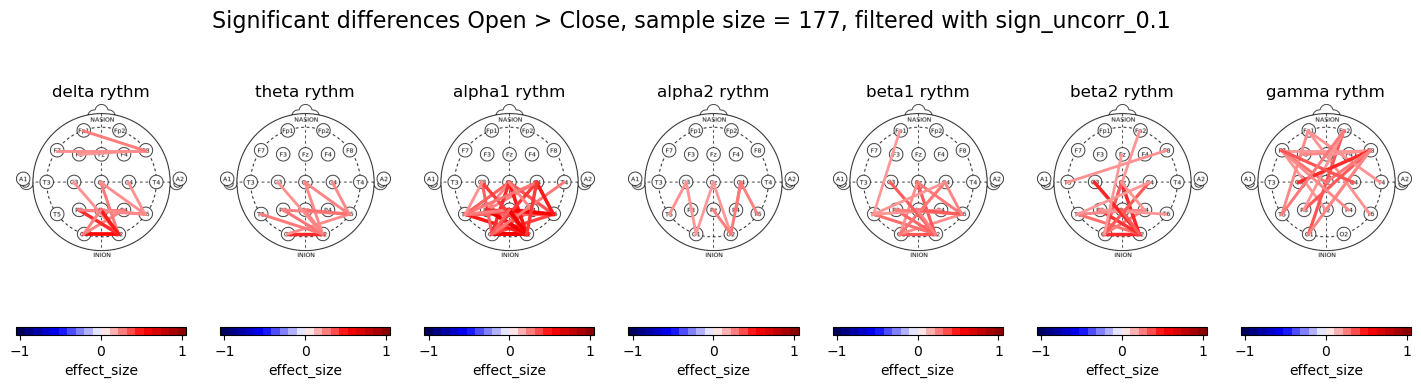

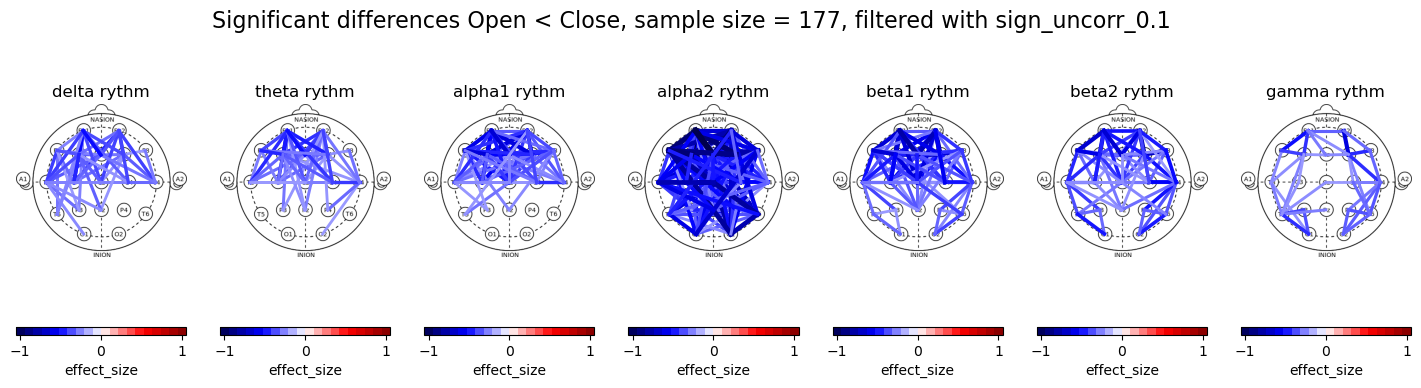

In [91]:
draw_obj = DrawEEG(img_source='../21ch_eeg.png')
thrs = 0.15
stat_df[f'sign_eff_thrs_{thrs}'] = (stat_df['low_eff_size']>thrs) | (stat_df['upper_eff_size']<-thrs)
stat_df['sign_uncorr_0.1'] = stat_df['p_val']<0.01
stat_df['width'] = stat_df[['mean_eff_size']].applymap(lambda x: np.exp(abs(x)) * np.exp(0.5))
fig = draw_obj.draw_by_df(stat_df, band=tuple(full_table.key_bands.values()),
                                 filter_by=f'sign_uncorr_0.1',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

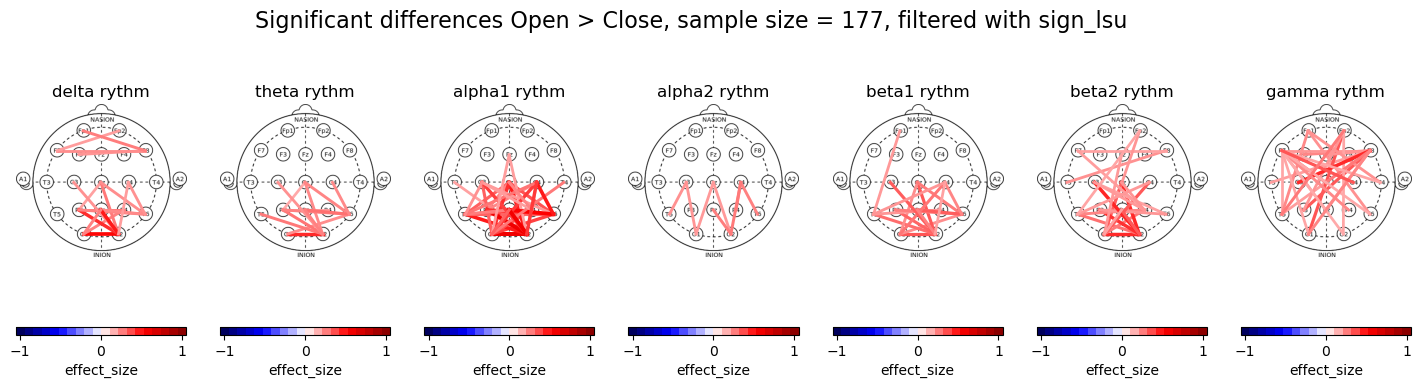

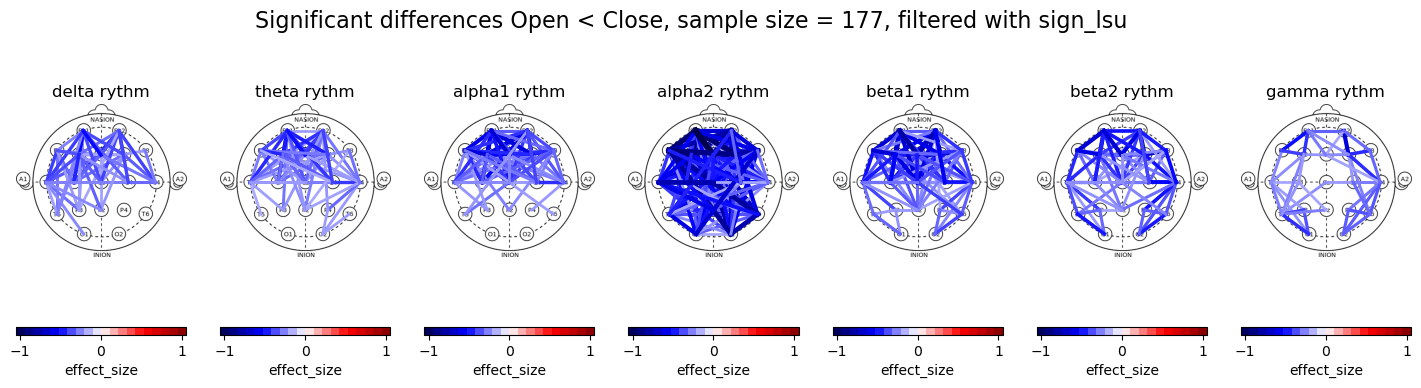

In [47]:
fig = draw_obj.draw_by_df(stat_df, band=tuple(full_table.key_bands.values()),
                                 filter_by='sign_lsu',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

In [100]:
sample_size=30
small_df = df.loc[list(np.random.choice(df.index, size=sample_size, replace=False))]
small_table = SynchronizationTable(small_df)

In [104]:
small_stat_df = small_table.compute_stat_df(bts_num=1000)
small_stat_df['sign_uncorr_0.01'] = small_stat_df['p_val']<0.01

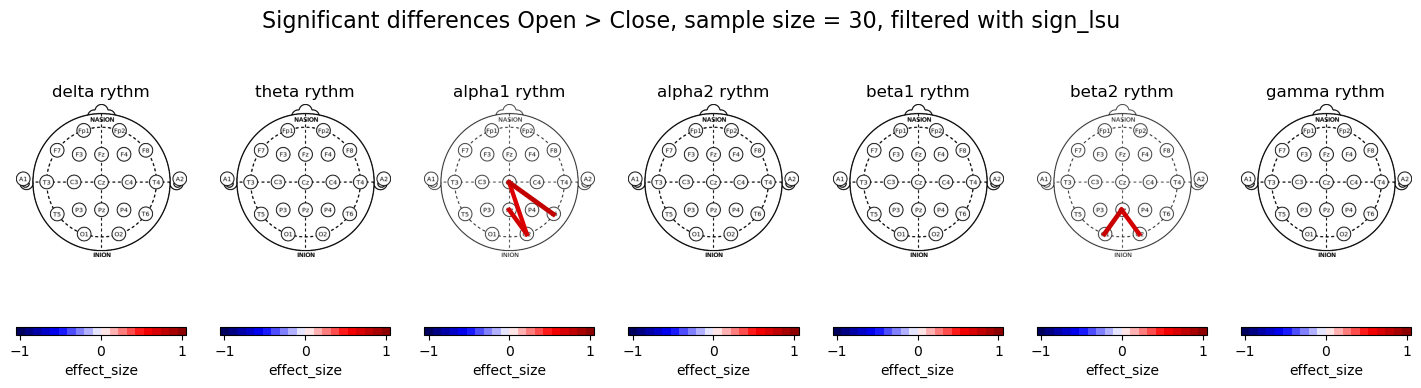

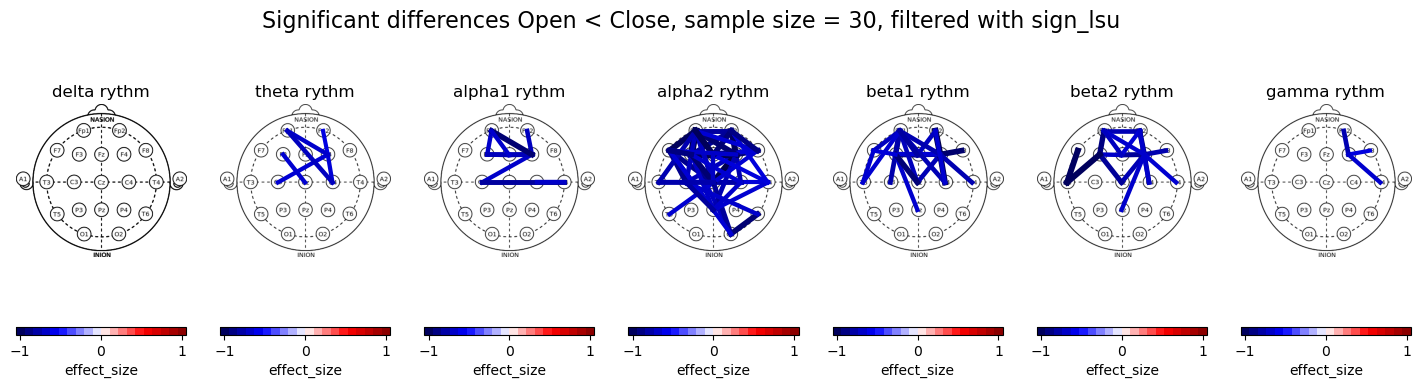

In [108]:
thrs = 0.05
small_stat_df[f'sign_eff_thrs_{thrs}'] = (small_stat_df['low_eff_size']>thrs) | (small_stat_df['upper_eff_size']<-thrs)
small_stat_df['width'] = small_stat_df[['mean_eff_size']].applymap(lambda x: np.exp(abs(x)) * np.exp(0.5))
fig = draw_obj.draw_by_df(small_stat_df, band=tuple(full_table.key_bands.values()),
                                 filter_by='sign_lsu',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate',
                                 sample_size=sample_size)

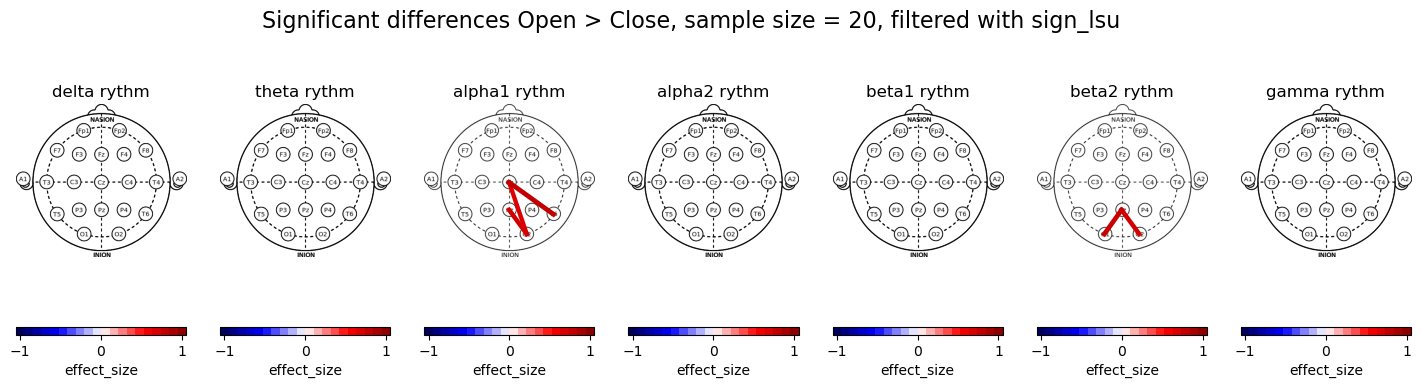

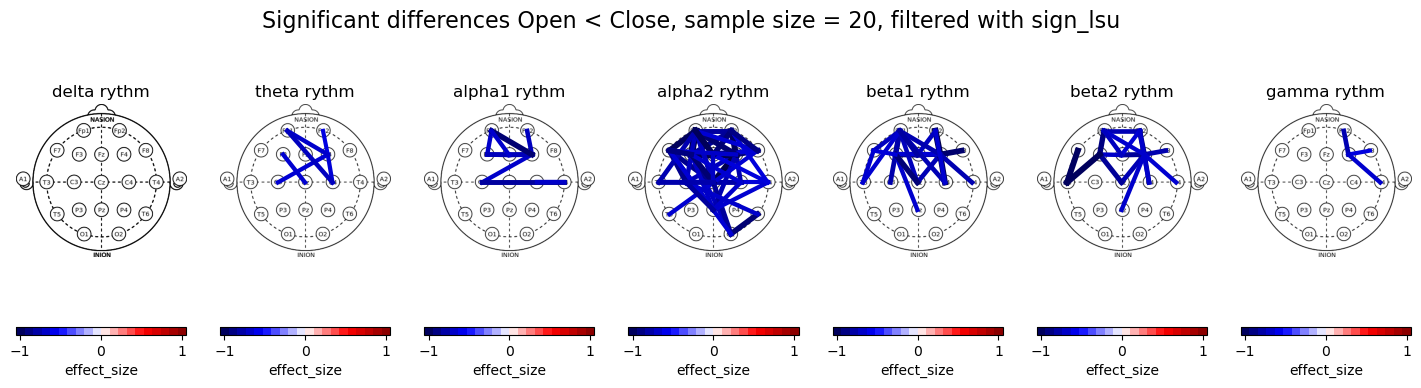

In [107]:
small_stat_df['width'] = small_stat_df[['mean_eff_size']].applymap(lambda x: np.exp(abs(x)) * np.exp(0.5))
fig = draw_obj.draw_by_df(small_stat_df, band=tuple(full_table.key_bands.values()),
                                 filter_by='sign_lsu',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate',
                                 sample_size=sample_size)

In [51]:
small_stat_df

,chan_pair,band,p_val,sign_holm_bonferroni,sign_sidak,sign_bonferroni,sign_lsu,mean_eff_size,low_eff_size,upper_eff_size,sign_eff_thrs,width
0,Fz/T6,delta,0.533624,False,False,False,False,-0.237121,-0.976148,0.247928,False,2.089911
1,Cz/Pz,delta,0.184613,False,False,False,False,-0.327550,-0.787093,0.135200,False,2.287707
2,F3/O2,delta,0.234821,False,False,False,False,-0.355823,-1.080360,0.126834,False,2.353311
3,Cz/T4,delta,0.345811,False,False,False,False,-0.201071,-0.654512,0.280345,False,2.015912
4,F4/C3,delta,0.208438,False,False,False,False,-0.302327,-0.721016,0.160607,False,2.230725
...,...,...,...,...,...,...,...,...,...,...,...,...
1192,F8/T4,gamma,0.051019,False,False,False,False,-0.519750,-1.155590,-0.015441,False,2.772501
1193,Fp2/T5,gamma,0.034067,False,False,False,False,0.543370,0.119681,1.006455,True,2.838768
1194,T3/Cz,gamma,0.309856,False,False,False,False,0.239414,-0.210057,0.680186,False,2.094707
1195,Fp2/C4,gamma,0.608240,False,False,False,False,0.121162,-0.343105,0.564488,False,1.861089


In [52]:
stat_df.filter(regex = 'sign').sum()

sign_holm_bonferroni    301
sign_sidak              294
sign_bonferroni         292
sign_lsu                642
sign_eff_thrs           446
dtype: int64

In [50]:
small_stat_df.filter(regex = 'sign').sum()

sign_holm_bonferroni      7
sign_sidak                7
sign_bonferroni           7
sign_lsu                 75
sign_eff_thrs           259
dtype: int64

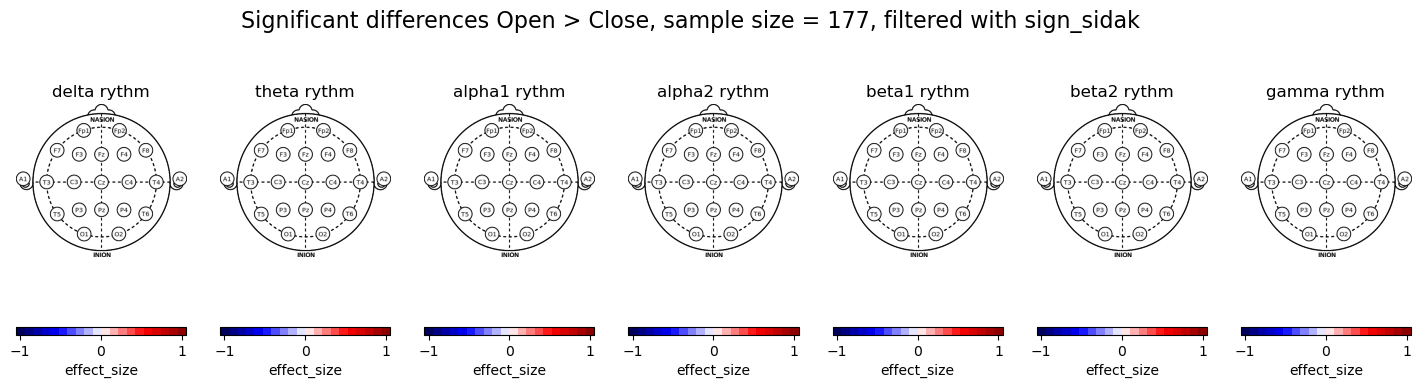

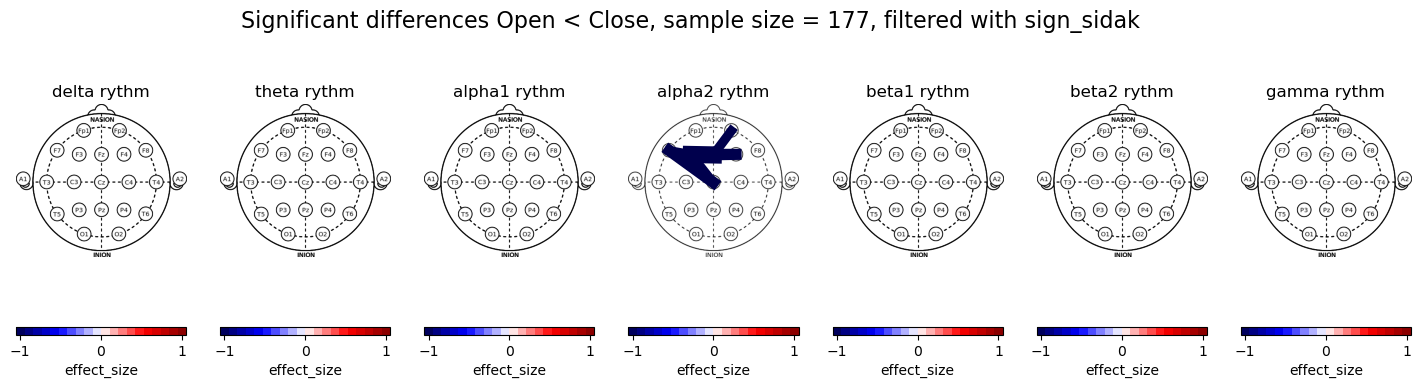

In [42]:
fig = draw_obj.draw_by_df(small_stat_df, band=tuple(full_table.key_bands.values()),
                                 filter_by='sign_sidak',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

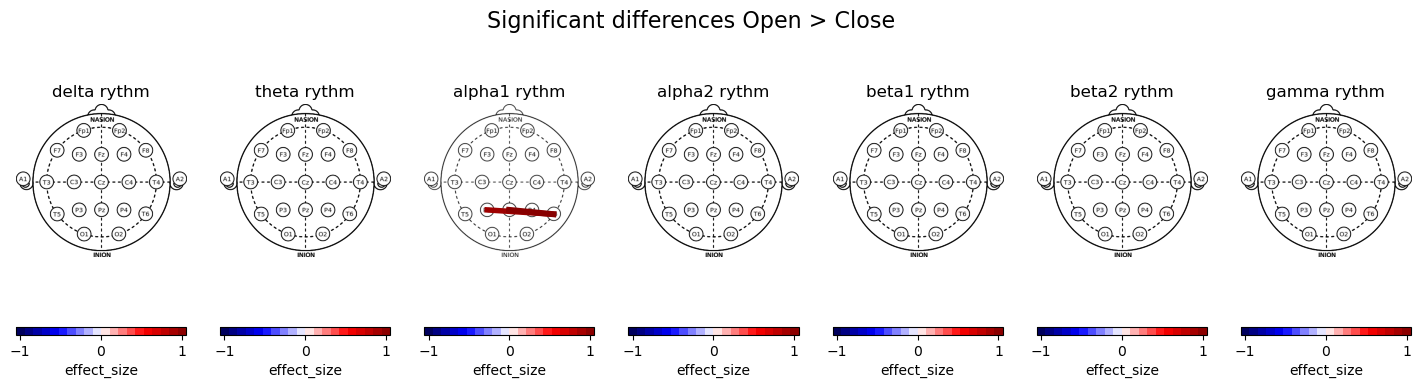

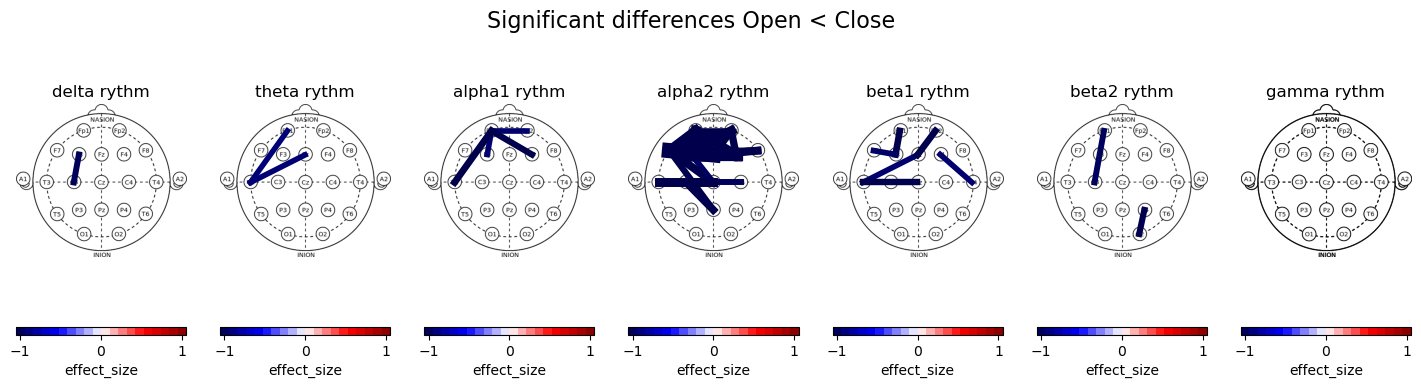

In [28]:
fig = draw_obj.draw_by_df(small_stat_df, band=tuple(full_table.key_bands.values()),
                                 filter_by='sign_lsu',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

In [68]:
stat_df['sign_eff_mean'] = (stat_df['mean_eff_size']>0.2) | (stat_df['mean_eff_size']<-0.2)

In [69]:
cols = list(stat_df.filter(regex='sign').columns)

In [70]:
[stat_df[col].sum() for col in cols]

[301, 294, 292, 642, 444, 564]

In [72]:
vec_2_arr_bool_dice(stat_df.sign_eff_mean.values, stat_df.filter(regex='sign').values)

[0.6959537572254335,
 0.6853146853146853,
 0.6822429906542056,
 0.9353233830845771,
 0.8809523809523809,
 1.0]

In [73]:
vec_2_arr_bool_dice(stat_df.sign_eff_range.values, stat_df.filter(regex='sign').values)

[0.8080536912751678,
 0.7967479674796748,
 0.7934782608695652,
 0.8176795580110497,
 1.0,
 0.8809523809523809]

In [43]:
(stat_df.sign_sidak==stat_df.sign_bonferroni).all()

False

In [35]:
bool_dice(stat_df.sign_sidak.values, stat_df.sign_eff_thrs.values)

0.7956698240866035

In [101]:
bands = tuple(full_table.key_bands.values())
bands
print(stat_df.columns)

Index(['chan_pair', 'band', 'p_val', 'sign_holm_bonferroni', 'sign_hochberg',
       'sign_sidak', 'sign_bonferroni', 'sign_lsu', 'sign_abh',
       'mean_eff_size', 'low_eff_size', 'upper_eff_size'],
      dtype='object')


In [104]:
draw_obj = DrawEEG(img_source='../21ch_eeg.png')

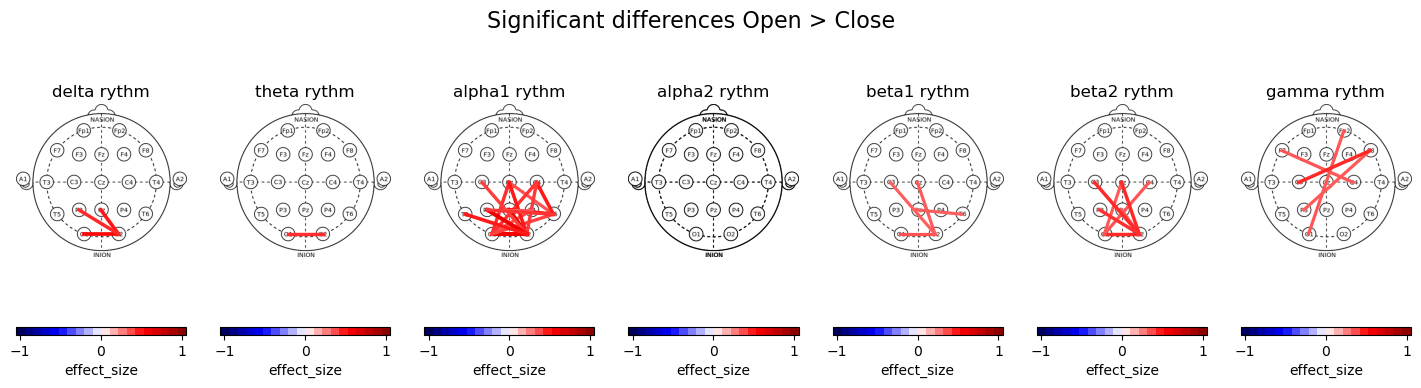

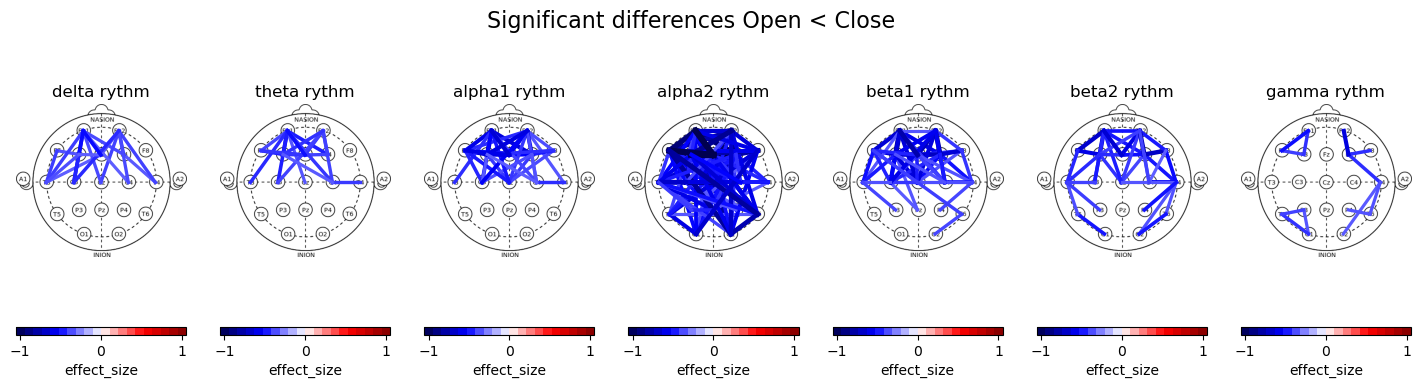

In [105]:
stat_df['width'] = stat_df[['mean_eff_size']].applymap(lambda x: np.exp(abs(x)) * np.exp(0.5))
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_holm_bonferroni',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')
plt.show()

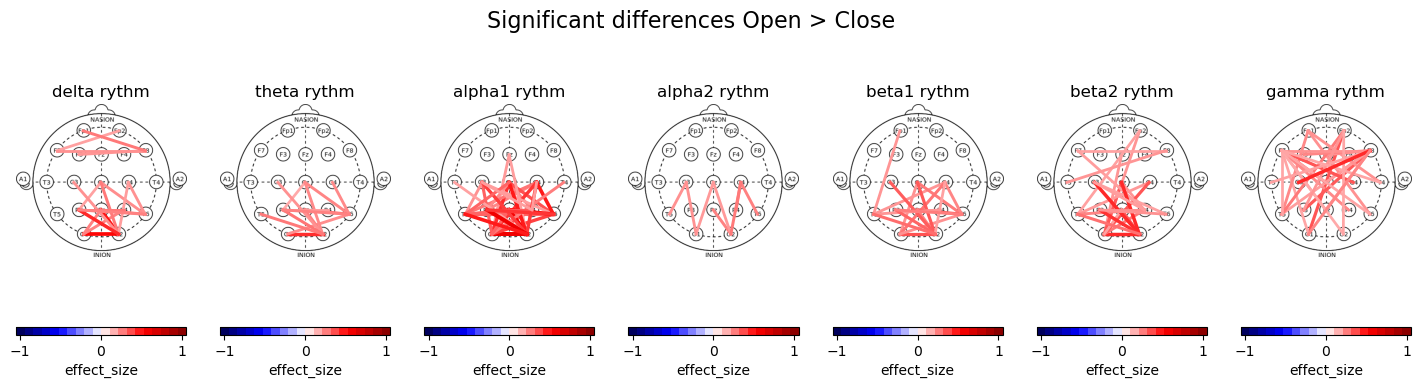

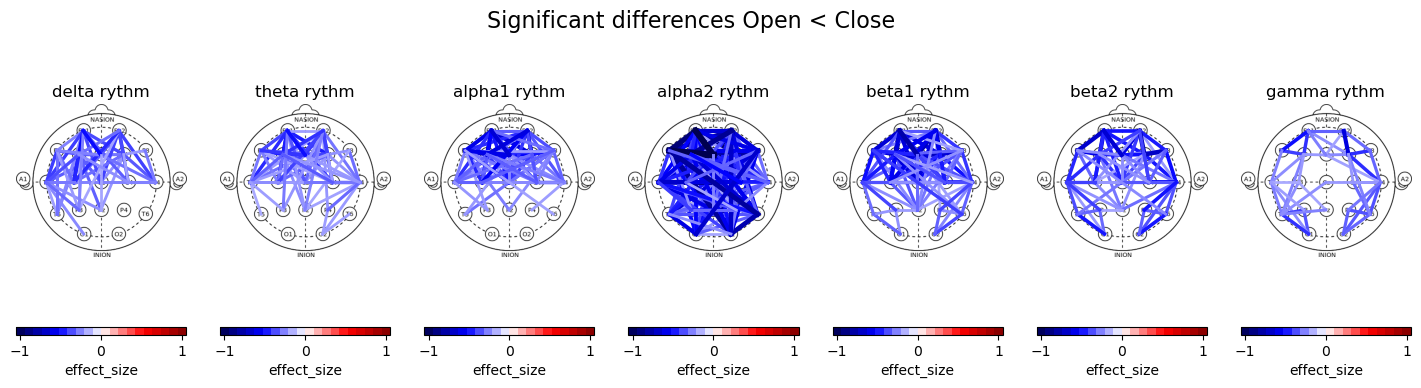

In [107]:
fig = draw_obj.draw_by_df(stat_df, band=tuple(table.key_bands.values(),
                                 filter_by='sign_lsu',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')
plt.show()

In [113]:
stat_df

,chan_pair,band,p_val,sign_holm_bonferroni,sign_hochberg,sign_sidak,sign_bonferroni,sign_lsu,sign_abh,mean_eff_size,low_eff_size,upper_eff_size,width,sign_eff_thrs
0,Fp2/O1,delta,6.490125e-01,False,False,False,False,False,False,-0.034279,-0.184989,0.110438,1.706218,False
1,Fz/O1,delta,7.938451e-01,False,False,False,False,False,False,-0.017664,-0.168244,0.131593,1.678102,False
2,P3/O1,delta,3.146559e-01,False,False,False,False,False,False,-0.071358,-0.206863,0.083497,1.770669,False
3,Fp2/P4,delta,7.621522e-02,False,False,False,False,False,False,-0.137115,-0.294644,0.005333,1.891018,False
4,T3/O1,delta,2.232874e-03,False,False,False,False,True,True,-0.234029,-0.364724,-0.098604,2.083457,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,C3/P4,gamma,1.691267e-01,False,False,False,False,False,False,0.103442,-0.042391,0.237737,1.828401,False
1193,T5/O2,gamma,3.418104e-01,False,False,False,False,False,False,-0.070268,-0.214335,0.067410,1.768741,False
1194,F8/C3,gamma,1.301965e-07,True,True,True,True,True,True,0.415298,0.262353,0.558399,2.497518,True
1195,F8/O1,gamma,1.941569e-03,False,False,False,False,True,True,0.237039,0.088201,0.389631,2.089738,False


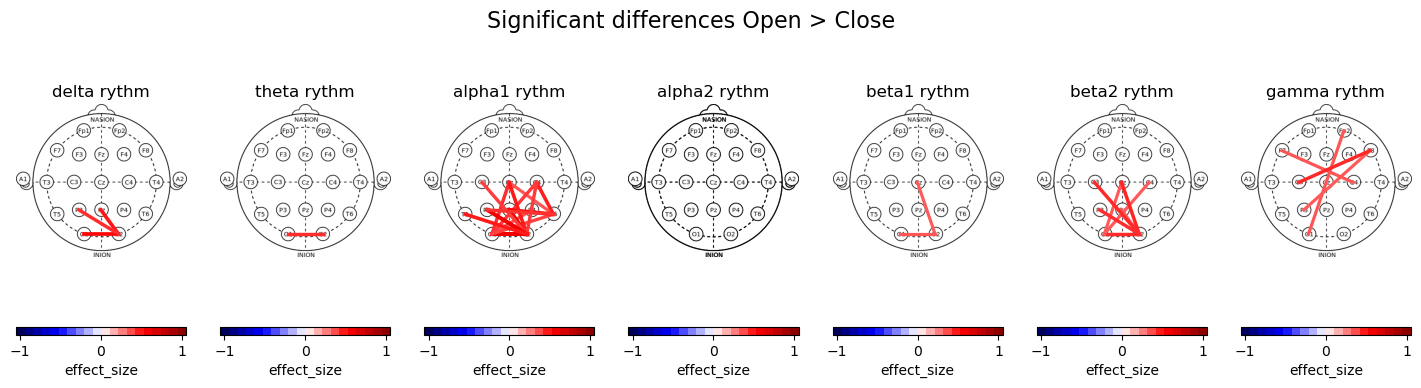

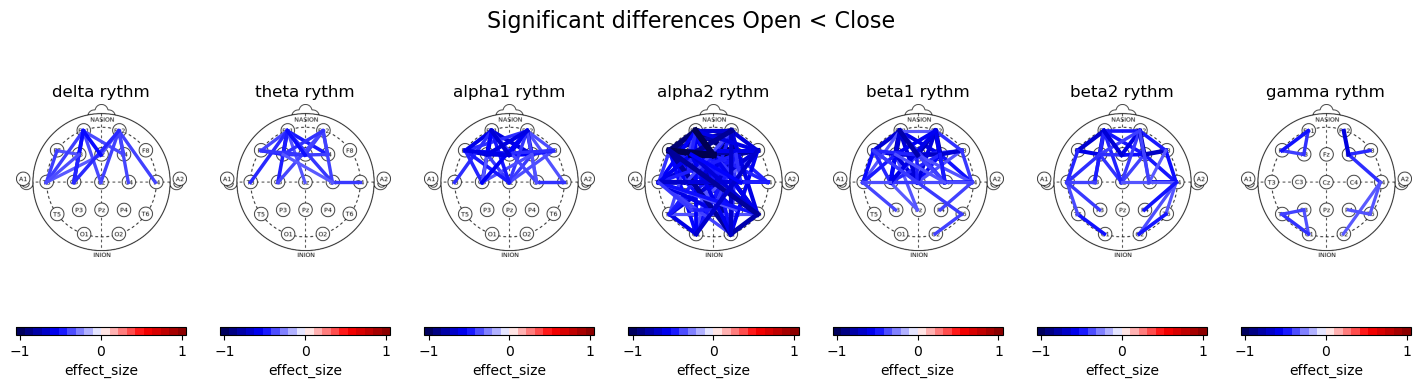

In [25]:
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_bonferroni',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

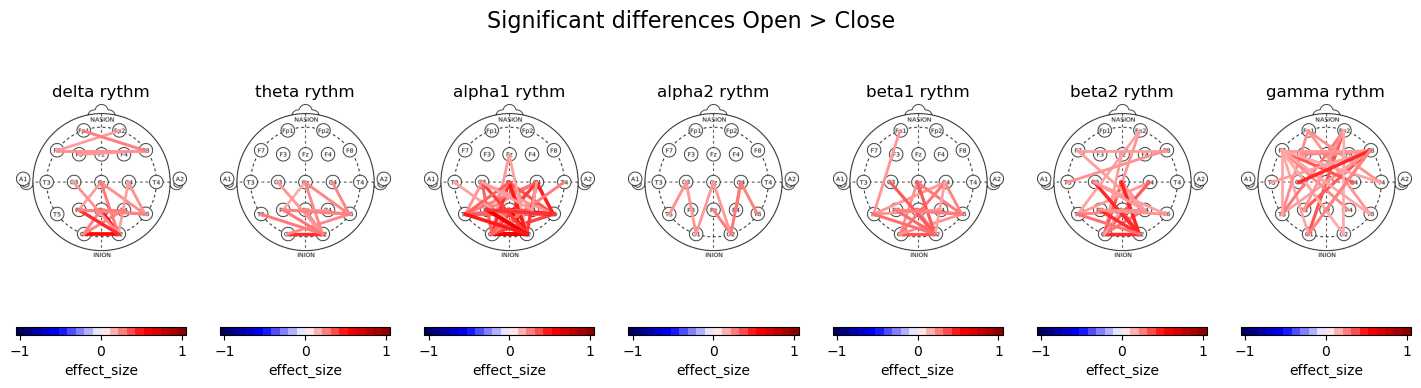

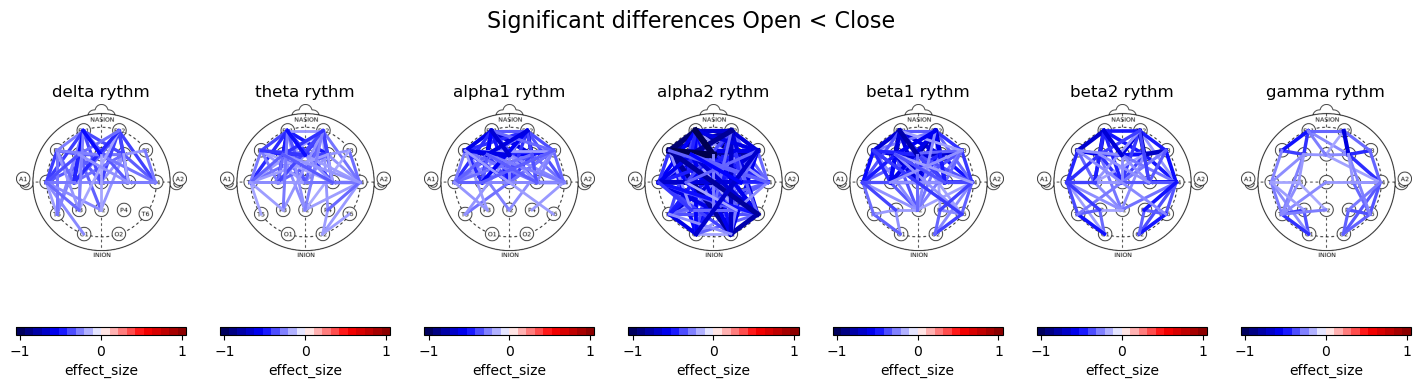

In [27]:
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_abh',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

438

In [110]:
stat_df['sign_eff_thrs'] = (stat_df['low_eff_size']>0.1) | (stat_df['upper_eff_size']<-0.1)

In [111]:
(stat_df['sign_eff_thrs']).sum(), stat_df['sign_abh'].sum()

(448, 642)

In [6]:
((stat_df['low_eff_size']>0.1) | (stat_df['upper_eff_size']<-0.1)).sum()
fig = draw_obj.draw_by_df(stat_df, band=bands,
                                 filter_by='sign_eff_thrs',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

NameError: name 'draw_obj' is not defined

In [54]:
stat_df.filter(regex='sign')

,sign_holm_bonferroni,sign_hochberg,sign_sidak,sign_bonferroni,sign_lsu,sign_abh,sign_eff_thrs
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...
1192,False,False,False,False,False,False,False
1193,False,False,False,False,False,False,False
1194,True,True,True,True,True,True,True
1195,False,False,False,False,True,True,False


In [51]:
arr = stat_df.filter(regex='sign').values

In [55]:
pairwise_bool_dice(arr)

[1.0,
 0.9882352941176471,
 0.984822934232715,
 0.6383881230116649,
 0.6383881230116649,
 0.8146143437077131,
 0.9882352941176471,
 0.984822934232715,
 0.6383881230116649,
 0.6383881230116649,
 0.8146143437077131,
 0.9965870307167235,
 0.6282051282051282,
 0.6282051282051282,
 0.8032786885245902,
 0.6252676659528907,
 0.6252676659528907,
 0.8,
 1.0,
 0.8111111111111111,
 0.8111111111111111]

## Что надо сделать 
Посмотреть как для разных корректировок путешествует значимости

In [22]:
small_df = df.loc[list(np.random.choice(df.index, size=40, replace=False))]
small_table = SynchronizationTable(small_df)
small_stat_df = small_table.compute_stat_df(bts_num=1000)
small_stat_df['sign_eff_thrs'] = (small_stat_df['low_eff_size']>0.05) | (small_stat_df['upper_eff_size']<-0.05)
small_stat_df['width'] = small_stat_df[['mean_eff_size']].applymap(lambda x: np.exp(abs(x)) * np.exp(0.5))
small_stat_df['sign_eff_thrs'] = (small_stat_df['low_eff_size']>0.05) | (small_stat_df['upper_eff_size']<-0.05)
small_stat_df['width'] = small_stat_df[['mean_eff_size']].applymap(lambda x: np.exp(abs(x)) * np.exp(0.5))
fig = draw_obj.draw_by_df(small_stat_df, band=bands,
                                 filter_by='sign_lsu',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')

NameError: name 'bands' is not defined

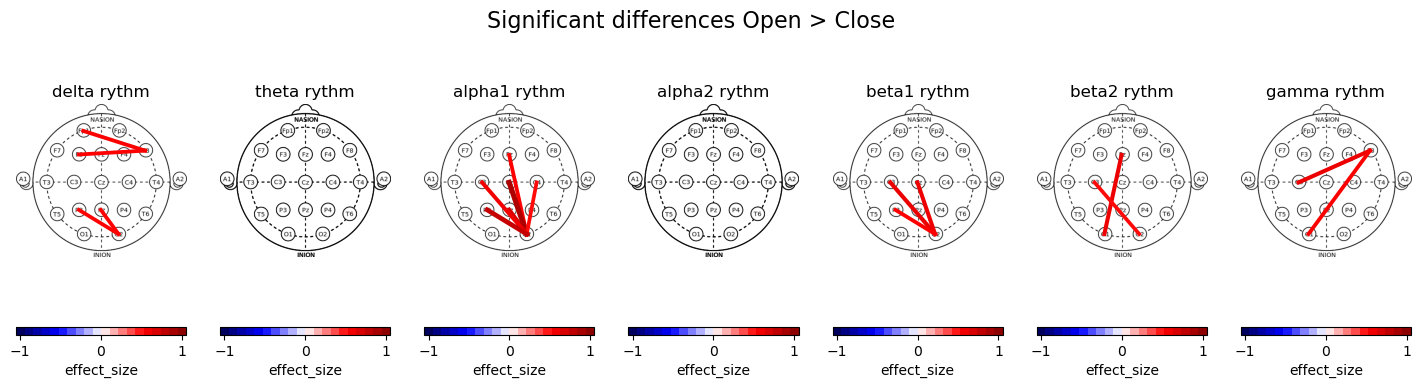

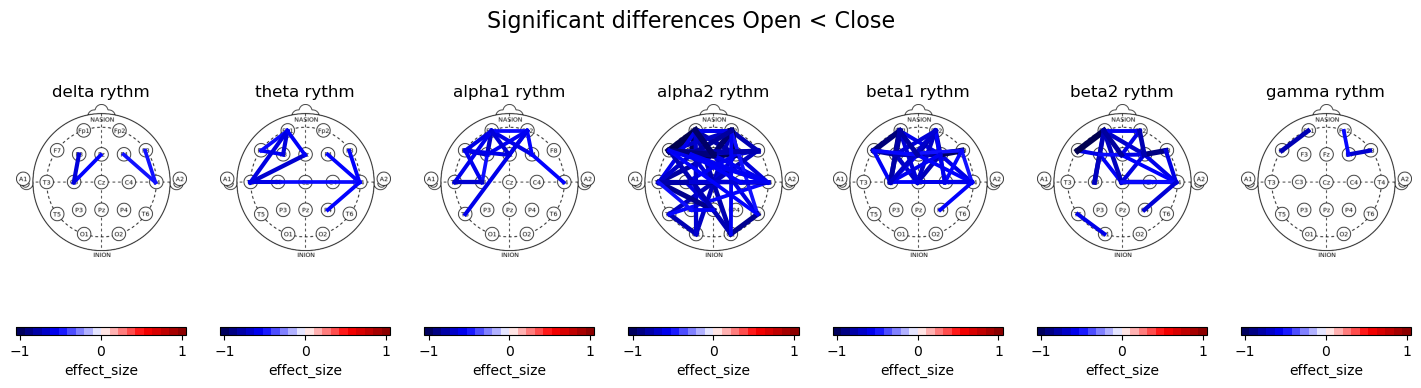

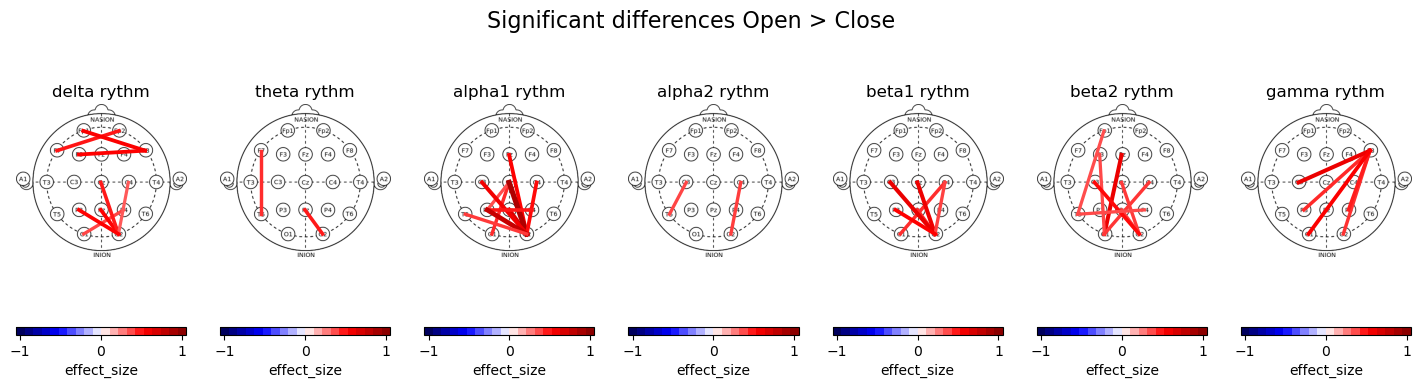

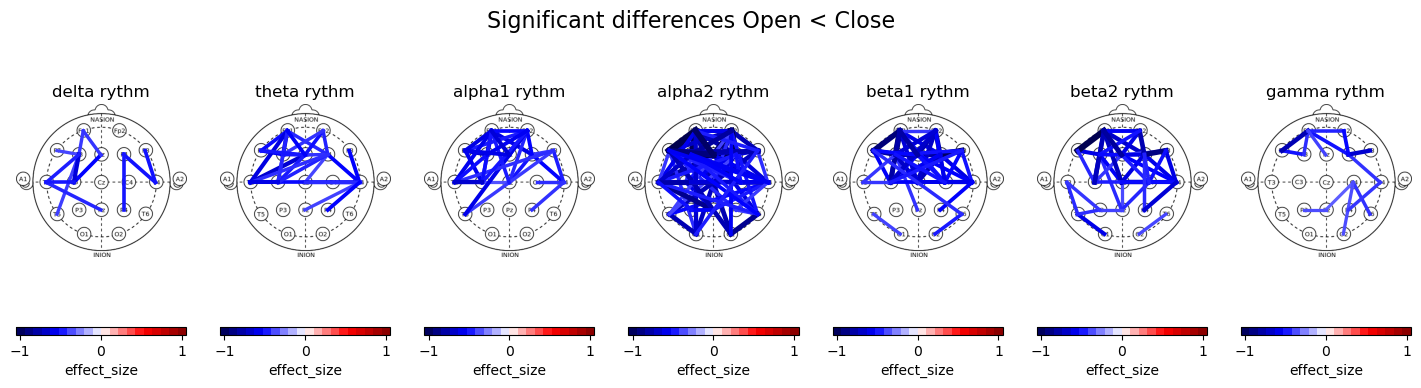

In [95]:
fig = draw_obj.draw_by_df(small_stat_df, band=bands,
                                 filter_by='sign_eff_thrs',
                                 color_col='mean_eff_size',
                                 width_col='width',
                                 sign='separate')